# **Importing libraries**

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as T

# **Loading Dataset**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download the dataset
!kaggle competitions download -c ee-5179-modern-computer-vision-course-competition

# Unzip (replace with actual zip filename)
!unzip -q ee-5179-modern-computer-vision-course-competition.zip -d data

# **Model using Midas**

In [4]:
# 1. Dataset class

class SPADDataset(Dataset):
    def __init__(self, spad_dir, depth_dir, transform=None):
        self.spad_dir = spad_dir
        self.depth_dir = depth_dir
        self.spad_files = sorted(os.listdir(spad_dir))
        self.depth_files = sorted(os.listdir(depth_dir))
        self.transform = transform

    def __len__(self):
        return len(self.spad_files)

    def __getitem__(self, idx):
        spad_path = os.path.join(self.spad_dir, self.spad_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])

        spad = Image.open(spad_path).convert('L')   # Loading as grayscale
        depth = Image.open(depth_path)

        spad = np.array(spad, dtype=np.float32) / 255.0
        depth = np.array(depth, dtype=np.float32)

        spad = torch.from_numpy(spad).unsqueeze(0)   # (1, H, W)
        depth = torch.from_numpy(depth).unsqueeze(0) # (1, H, W)

        if self.transform:
            spad = self.transform(spad)
            depth = self.transform(depth)

        return spad, depth


# 2. Model class

class SPADMiDaS(nn.Module):
    def __init__(self, pretrained=True):
        super(SPADMiDaS, self).__init__()
        self.midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small" if pretrained else "MiDaS_small")

        # Slight denoising helps SPAD input
        self.denoise = T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))

    def forward(self, x):
        if x.shape[1] == 1:
            x = self.denoise(x)
            x = x.repeat(1, 3, 1, 1)  # Repeating  1 channel to 3

        x = self.midas(x)

        # Ensuing output size (N, 1, 256, 256)
        if x.ndim == 3:
            x = x.unsqueeze(1)
        if x.shape[2] != 256 or x.shape[3] != 256:
            x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

        return x

# 3. Loss function

def rmse_loss(pred, target):
    return torch.sqrt(F.mse_loss(pred, target))

# 4. Train function

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for spad, depth in train_loader:
            spad, depth = spad.to(device), depth.to(device)

            optimizer.zero_grad()
            pred = model(spad)

            loss = rmse_loss(pred, depth)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for spad, depth in val_loader:
                spad, depth = spad.to(device), depth.to(device)
                pred = model(spad)
                loss = rmse_loss(pred, depth)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_spad_midas')
            print("✅ Saved best model")

    return model

# 5. Prepare everything and train

if __name__ == "__main__":
    train_spad_dir = '/content/data/competition-data/training-images'
    train_depth_dir = '/content/data/competition-data/training-depths'
    val_spad_dir = '/content/data/competition-data/validation-images'
    val_depth_dir =  '/content/data/competition-data/validation-depths'

    # Datasets and Loaders
    train_dataset = SPADDataset(train_spad_dir, train_depth_dir)
    val_dataset = SPADDataset(val_spad_dir, val_depth_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

    # Model
    model = SPADMiDaS(pretrained=True)

    # Train
    model = train_model(model, train_loader, val_loader, epochs=50)

    # Save final model
    torch.save(model.state_dict(), 'final_spad_midas')
    print("🎯 Training complete and model saved!")


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt
100%|██████████| 81.8M/81.8M [00:00<00:00, 121MB/s]


Epoch [1/50] Train Loss: 50.9028 | Val Loss: 107.5407
✅ Saved best model
Epoch [2/50] Train Loss: 42.7323 | Val Loss: 95.6105
✅ Saved best model
Epoch [3/50] Train Loss: 38.3220 | Val Loss: 88.9645
✅ Saved best model
Epoch [4/50] Train Loss: 35.2317 | Val Loss: 77.4701
✅ Saved best model
Epoch [5/50] Train Loss: 32.6523 | Val Loss: 68.0479
✅ Saved best model
Epoch [6/50] Train Loss: 30.3277 | Val Loss: 68.7186
Epoch [7/50] Train Loss: 28.6357 | Val Loss: 69.8973
Epoch [8/50] Train Loss: 26.8004 | Val Loss: 56.4228
✅ Saved best model
Epoch [9/50] Train Loss: 25.4150 | Val Loss: 61.9607
Epoch [10/50] Train Loss: 24.5347 | Val Loss: 54.6048
✅ Saved best model
Epoch [11/50] Train Loss: 23.5034 | Val Loss: 63.4223
Epoch [12/50] Train Loss: 22.6747 | Val Loss: 54.6288
Epoch [13/50] Train Loss: 21.7846 | Val Loss: 55.6643
Epoch [14/50] Train Loss: 21.0258 | Val Loss: 50.4200
✅ Saved best model
Epoch [15/50] Train Loss: 20.5660 | Val Loss: 47.9708
✅ Saved best model
Epoch [16/50] Train Loss: 2

# **Testing and Plotting**

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


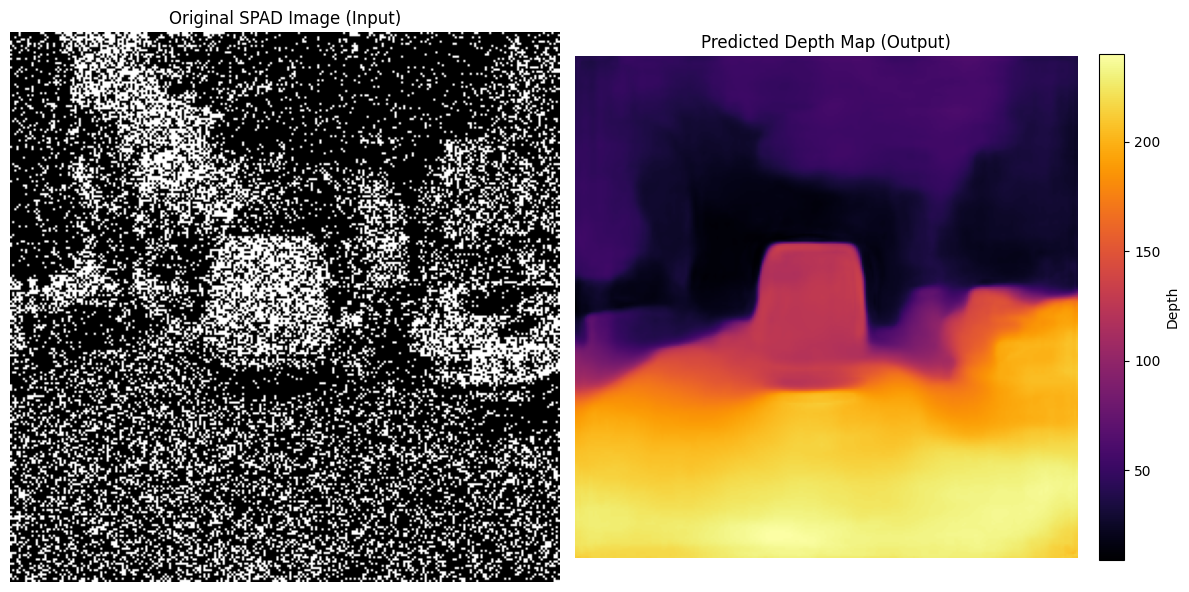

In [9]:
def test_image(model, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Load your SPAD input image
    spad = Image.open(image_path).convert('L')  # 'L' = grayscale (1-channel)
    spad_array = np.array(spad, dtype=np.float32) / 255.0  # Normalize 0-1
    spad_tensor = torch.from_numpy(spad_array).unsqueeze(0).unsqueeze(0)  # Shape (1,1,H,W)

    with torch.no_grad():
        spad_tensor = spad_tensor.to(device)
        pred_depth = model(spad_tensor)
        pred_depth = pred_depth.squeeze().cpu().numpy()  # Shape (H, W)

    return spad_array, pred_depth

# ---------------------------------
# Load trained model
model = SPADMiDaS(pretrained=False)
model.load_state_dict(torch.load('final_spad_midas', map_location='cpu'))
model.eval()

# Test on a single SPAD image
test_spad_image = '/content/data/competition-data/testing-images/95191.png'  # <--- change this to your SPAD test image

spad_image, predicted_depth = test_image(model, test_spad_image)

# ---------------------------------
# 📈 Plotting original and predicted side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Original noisy SPAD image
axs[0].imshow(spad_image, cmap='gray')
axs[0].set_title('Original SPAD Image (Input)')
axs[0].axis('off')

# Predicted depth
depth_plot = axs[1].imshow(predicted_depth, cmap='inferno')
axs[1].set_title('Predicted Depth Map (Output)')
axs[1].axis('off')

# Colorbar for depth
fig.colorbar(depth_plot, ax=axs[1], fraction=0.046, pad=0.04, label='Depth')

plt.tight_layout()
plt.show()


In [12]:
# 1. Load the trained model
model = SPADMiDaS(pretrained=False)
model.load_state_dict(torch.load('final_spad_midas', map_location='cpu'))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 2. Define prediction function
def predict_and_save(model, input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    test_images = sorted(os.listdir(input_folder))
    for img_name in test_images:
        if img_name.endswith('.png'):
            # Read image
            img_path = os.path.join(input_folder, img_name)
            spad = Image.open(img_path).convert('L')
            spad_array = np.array(spad, dtype=np.float32) / 255.0
            spad_tensor = torch.from_numpy(spad_array).unsqueeze(0).unsqueeze(0).to(device)

            with torch.no_grad():
                pred_depth = model(spad_tensor)
                pred_depth = pred_depth.squeeze().cpu().numpy()

            # Normalize prediction
            pred_depth_norm = (pred_depth - np.min(pred_depth)) / (np.max(pred_depth) - np.min(pred_depth) + 1e-6)
            pred_depth_img = (pred_depth_norm * 255.).astype(np.uint8)

            # Save prediction
            save_path = os.path.join(output_folder, img_name)
            cv2.imwrite(save_path, pred_depth_img)

# 3. Paths
test_images_folder = "/content/data/competition-data/testing-images"
predictions_save_folder = "/content/data/Depth_prediction"

# 4. Predict and save images
predict_and_save(model, test_images_folder, predictions_save_folder)

print("✅ All predictions saved as images in:", predictions_save_folder)

# ------------------------------------------
# 5. Now Convert saved prediction images to CSV

def images_to_csv_with_metadata(image_folder, output_csv):
    data = []

    for idx, filename in enumerate(sorted(os.listdir(image_folder))):
        if filename.endswith(".png"):
            filepath = os.path.join(image_folder, filename)
            image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
            image = cv2.resize(image, (128, 128))
            image = image / 255.
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)
            image = np.uint8(image * 255.)
            image_flat = image.flatten()
            row = [idx, filename] + image_flat.tolist()
            data.append(row)

    num_columns = len(data[0]) - 2 if data else 0
    column_names = ["id", "ImageID"] + [indx for indx in range(num_columns)]
    df = pd.DataFrame(data, columns=column_names)
    df.to_csv(output_csv, index=False)

# CSV Output path
predictions_csv = "/content/predictions.csv"

# Convert
images_to_csv_with_metadata(predictions_save_folder, predictions_csv)

print("✅ CSV created at:", predictions_csv)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None
✅ All predictions saved as images in: /content/data/Depth_prediction
✅ CSV created at: /content/predictions.csv


In [16]:
!zip -r /content/sample_solution.zip /content/data/Depth_prediction


updating: content/data/Depth_prediction/ (stored 0%)
updating: content/data/Depth_prediction/36557311.png (deflated 3%)
updating: content/data/Depth_prediction/24454892.png (deflated 4%)
updating: content/data/Depth_prediction/105212.png (deflated 5%)
updating: content/data/Depth_prediction/35457091.png (deflated 4%)
updating: content/data/Depth_prediction/6251251.png (deflated 5%)
updating: content/data/Depth_prediction/175351.png (deflated 3%)
updating: content/data/Depth_prediction/23054612.png (deflated 6%)
updating: content/data/Depth_prediction/14652931.png (deflated 7%)
updating: content/data/Depth_prediction/41558311.png (deflated 5%)
updating: content/data/Depth_prediction/25355071.png (deflated 5%)
updating: content/data/Depth_prediction/23554712.png (deflated 3%)
updating: content/data/Depth_prediction/12752551.png (deflated 5%)
updating: content/data/Depth_prediction/25455091.png (deflated 3%)
updating: content/data/Depth_prediction/13152632.png (deflated 5%)
updating: cont

In [18]:
from google.colab import files
files.download('/content/sample_solution.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>